# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

## Import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD


## Load Data
Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

In [3]:
n_users = 50
user_tr_len = pickle.load(open('./data/user_tr_len.pkl','rb'))

user_train_data_tensors = pickle.load(open('./data/user_train_data_tensors.pkl','rb'))
user_train_label_tensors = pickle.load(open('./data/user_train_label_tensors.pkl','rb'))

val_data_tensor = pickle.load(open('./data/val_data_tensor.pkl','rb'))
val_label_tensor = pickle.load(open('./data/val_label_tensor.pkl','rb'))
te_data_tensor = pickle.load(open('./data/te_data_tensor.pkl','rb'))
te_label_tensor = pickle.load(open('./data/te_label_tensor.pkl','rb'))

## Our Aggregation Function

In [4]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    discarded_history = get_discarded_index(n_attackers, history_updates)

    mask = torch.ones(all_updates.size(0), dtype=torch.bool)
    mask[discarded_history] = False
    remaining_updates = all_updates[mask]

    print('discarded index', discarded_history)

    return torch.nanmean(remaining_updates, dim=0)

####
def euclidean_distance(row1, row2):
    return torch.sqrt(torch.sum((row1 - row2) ** 2))
####

def get_discarded_index(n_attackers, history_updates):
    n_users = history_updates.shape[0]

    ####
    distance_matrix = [[0 if i == j else euclidean_distance(history_updates[i, :], history_updates[j, :]) for j in range(n_users)] for i in range(n_users)]
    ####

    sum_of_distances = [sum(row) for row in distance_matrix]

    discarded_history = []
    for _ in range(n_attackers):
        max_distance = max(sum_of_distances)
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)

        for i in range(n_users):
            sum_of_distances[i] -= distance_matrix[i][index_of_max_distance]
        sum_of_distances[index_of_max_distance] = -1

    return discarded_history


## Set nepochs

In [5]:
nepochs= 300

## LIE attack and our defense

In [6]:
def lie_attack(all_updates, z):
    avg = torch.mean(all_updates, dim=0)
    std = torch.std(all_updates, dim=0)
    return avg + z * std

In [8]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

at_type = 'multi-krum'

aggregation='bulyan'
multi_k = False
candidates = []

dev_type ='std'
n_attackers=[10]
z_values={3:0.69847, 5:0.7054, 8:0.71904, 10:0.72575, 12:0.73891}

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []

title = "LIE attack and our defense"

for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    ####
    history = torch.zeros((n_users, nepochs + 1), dtype=torch.float32).cuda()
    ####

    model_grads = []
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))


            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            mal_update = lie_attack(user_grads, z_values[n_attacker])
            malicious_grads = torch.cat((torch.stack([mal_update]*n_attacker), user_grads[n_attacker:]))
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        history[:, epoch_num] = updates_abs_mean.squeeze()
        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(f'{title}.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

discarded index [20, 34, 47, 15, 45, 39, 31, 29, 37, 17]
epoch: 0, bulyan: at multi-krum n_at 10 e 0 | val loss 2.3028 val acc 13.3117 best val_acc 13.311688


C:\Users\tians\AppData\Local\Temp\ipykernel_22104\1010853095.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index [20, 34, 47, 15, 39, 45, 29, 31, 18, 37]


KeyboardInterrupt: 

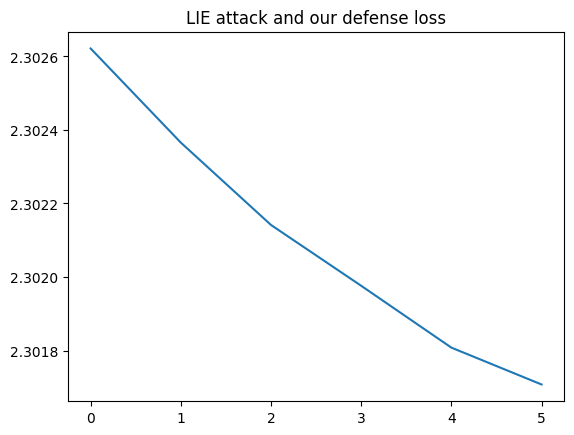

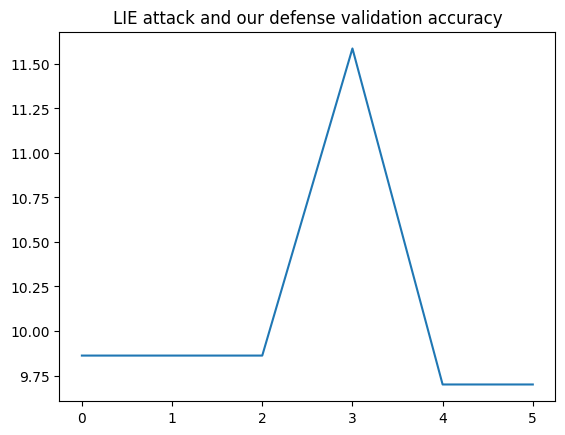

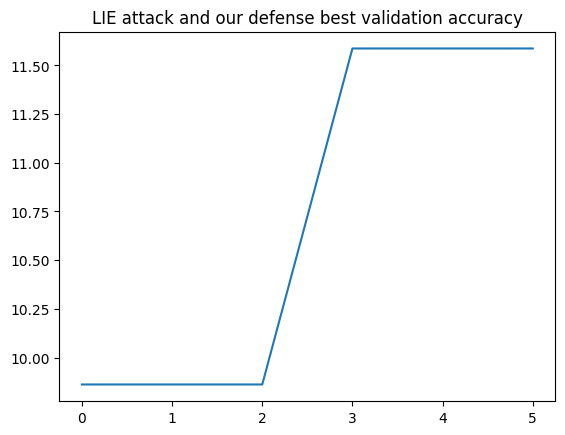

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title(f"{title} {col}")
    plt.show()